In [18]:
import nltk
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline


In [20]:
def print_metrics(y_act, y_pred):
    print("Accuracy:\t", accuracy_score(y_act, y_pred))
    print("Confusion matrix:\n",confusion_matrix(y_act, y_pred))
    print("Classification Report:\n",classification_report(y_act, y_pred))

In [3]:
train_df = pd.read_csv('../data/train_set.csv',encoding = "ISO-8859-1", engine='python')
test_df = pd.read_csv('../data/test_set.csv',encoding = "ISO-8859-1", engine='python')

In [4]:
train_df.shape, test_df.shape

((23615, 2), (5894, 1))

In [5]:
train_df.head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for c...
2,85389000,lv ma pd trip unit for cvs parts of circuit br...
3,85389000,lv na p trip unit for cvs switch parts of circ...
4,85389000,lv tmd pd trip unit for cvs parts of circuitbr...


In [6]:
train_df['text'][11]

'a compact fuseholder nwcmf electrical fuse linksactual user '

In [7]:
train_df[train_df['text'].str.contains('captive consumption')]['label'].value_counts()

87089900    988
87082900    968
85369090    272
39269099    226
73181500    141
85366990    110
85389000     70
85177090     22
85364900      9
85238090      1
84713010      1
Name: label, dtype: int64

In [8]:
## map labels 
label_map = {j:i for (i,j) in enumerate(train_df['label'].unique())}
label_rev_map = {i:j for (i,j) in enumerate(train_df['label'].unique())}

## mapping labels
train_df['label'] = train_df['label'].map(label_map)

In [9]:
def add_features(train_df):
    train_df['char_count'] = train_df['text'].apply(lambda x:len(x))
    train_df['word_count'] = train_df['text'].apply(lambda x:len(x.split()))
    return train_df

In [10]:
train_df = add_features(train_df)
test_df = add_features(test_df)

## Train val split 

In [12]:
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [13]:
train_df.shape, val_df.shape

((18892, 4), (4723, 4))

In [14]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

0     2345
1     2063
2     1967
3     1756
4     1607
5     1563
6     1382
7     1347
8     1322
9     1301
10    1166
11    1073
Name: label, dtype: int64


/home/arya/anaconda3/envs/my_env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='label'>

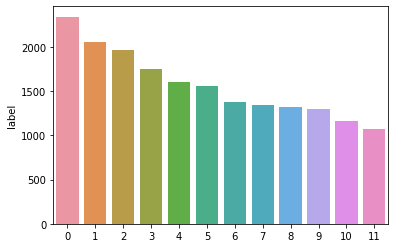

In [15]:
x=train_df['label'].value_counts()
print(x)
sns.barplot(x.index,x)

<h1> 1. BOW

In [14]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_df.text)
X_train_counts.shape

(18892, 12458)

In [15]:
X_val_counts = count_vect.transform(val_df.text)

X_test_counts = count_vect.transform(test_df.text)
X_val_counts.shape, X_test_counts.shape

((4723, 12458), (5894, 12458))

<H1> 2. TFIDF

In [16]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(18892, 12458)

In [17]:
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_val_tfidf.shape, X_test_tfidf.shape

((4723, 12458), (5894, 12458))

<h1> 3. Modelling

<h2> 3.1 Naive Bayes

In [18]:
clf = MultinomialNB().fit(X_train_tfidf, train_df.label)

## predict
ypred_val_nb = clf.predict(X_val_tfidf)

In [31]:
print_metrics(val_df['label'], ypred_val_nb)

Accuracy:	 0.895617192462418
Confusion matrix:
 [[518   2  23  10   1   9   6   0   2   0   1   0]
 [  6 533   1   8   0   0   0   0   1   0   1   0]
 [ 22   1 379   4   3  24  48   0   2   0   0   0]
 [ 25  18   6 341  18   3   2   1  17   1  10   0]
 [ 10  13   5   9 344   1   0   0   7   0   3   0]
 [ 21   3  32   2   1 315   2   0   0   0   0   0]
 [  4   0   7   0   2   0 325   0   2   0   0   0]
 [  3   0   0   1   2   0   0 347   1   0   0   0]
 [  8   5   3  12   9   0   0   0 266   0  14   0]
 [  0   0   0   0   0   0   0   0   0 317   0   0]
 [  5   0   1   1   1   1   0   0  23   0 270   0]
 [  0   0   0   3   0   0   0   0   0   0   0 275]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       572
           1       0.93      0.97      0.95       550
           2       0.83      0.78      0.81       483
           3       0.87      0.77      0.82       442
           4       0.90      0.88      0.89 

<h2> 3.2 SVM

In [35]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, \
                    random_state=42).fit(X_train_tfidf, train_df.label)

## predict
ypred_val_svm = clf.predict(X_val_tfidf)

/home/arya/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [36]:
print_metrics(val_df['label'], ypred_val_svm)

Accuracy:	 0.8615286893923354
Confusion matrix:
 [[486   5  35  12   3  12   8   0  10   0   0   1]
 [  8 530   0   5   3   1   0   0   3   0   0   0]
 [ 27  11 306   2   2  73  57   0   2   0   2   1]
 [ 27  34   4 309  16   7   4   1  24   1  10   5]
 [  3  11   3   8 356   1   0   0   7   0   3   0]
 [ 19   7  22   3   9 309   6   0   1   0   0   0]
 [  2   0   3   0   3   0 332   0   0   0   0   0]
 [  3   0   0   3   0   0   0 348   0   0   0   0]
 [ 17   3   1  16   6   0   2   0 254   0  16   2]
 [  0   0   0   0   0   0   0   0   0 317   0   0]
 [  7   0   0   2   0   2   0   0  45   0 246   0]
 [  0   0   0   2   0   0   0   0   0   0   0 276]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       572
           1       0.88      0.96      0.92       550
           2       0.82      0.63      0.71       483
           3       0.85      0.70      0.77       442
           4       0.89      0.91      0.90

In [ ]:
## stopword removal

In [21]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),])

text_clf.fit(train_df.text, train_df.label)
ypred_val_nb_sw = text_clf.predict(val_df.text)

print_metrics(val_df['label'], ypred_val_nb_sw)

Accuracy:	 0.8966758416260852
Confusion matrix:
 [[530   0  25  15   5  12   2   0   1   0   1   0]
 [  3 499   2  13   1   0   0   0   0   0   0   0]
 [ 27   3 361   7   1  23  45   0   4   0   0   0]
 [ 23  12   6 341  16   5   1   0  17   1  11   0]
 [  7  15   4  16 373   1   0   0   8   2   0   0]
 [ 16   0  35   2   1 324   3   0   0   0   0   0]
 [  2   0   6   0   0   0 324   0   0   0   0   0]
 [  2   0   1   0   0   0   0 370   0   0   0   0]
 [  6   2   1  17   7   0   0   0 298   0  20   0]
 [  0   0   0   0   0   0   0   0   0 304   0   0]
 [  0   1   0   1   0   0   0   0  28   1 254   0]
 [  1   0   0   0   0   0   0   0   0   0   0 257]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       591
           1       0.94      0.96      0.95       518
           2       0.82      0.77      0.79       471
           3       0.83      0.79      0.81       433
           4       0.92      0.88      0.90

In [22]:
ypred_test_nb_sw = text_clf.predict(test_df.text)
ypred_test_nb_sw = pd.Series(ypred_test_nb_sw)

In [26]:
ypred_test_nb_sw.value_counts()

0     737
1     663
2     590
4     524
5     518
3     514
8     450
6     446
7     395
9     386
10    337
11    334
dtype: int64

In [28]:
ypred_test_nb_sw.map(label_rev_map).value_counts()

85389000    737
85177090    663
85369090    590
73181500    524
85366990    518
39269099    514
87089900    450
85364900    446
85238090    395
33041000    386
87082900    337
84713010    334
dtype: int64

In [37]:
finalOutput = test_df[['text']].copy()
finalOutput['label'] = ypred_test_nb_sw.map(label_rev_map)

In [38]:
finalOutput

,text,label
0,lv tmd pd trip unit for nh parts of circuit br...,85389000
1,module tm analog outputs analog output expansi...,85389000
2,command group t iii mechanismt p parts forcir...,85389000
3,parts of relayelectrical contact issu e f xxup,85389000
4,parts for programmable logic controllers dm ...,85389000
...,...,...
5889,gdf latitude portable computernotebookassyba...,84713010
5890,cfjx precision portable computernotebook ass...,84713010
5891,eguujnnincnnnuas xuup acj note book computer l...,84713010
5892,egubjnninnnnums wwup note book computer laptop...,84713010


In [39]:
finalOutput.to_csv('../data/task2_pred_output.csv', index=False)

In [ ]:
## observations
tried stopword removal: helped
tried stemming: didnot helped
tried bow: tfidf gave better performance